In [1]:
import pandas as pd
import numpy as np
import math

## Load the data

In [2]:
col_name=['user_id','item_id', 'rating', 'timestamp']
df=pd.read_csv('ratings.data',sep='\t',names=col_name)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
n_user=df.user_id.unique().shape[0]
n_item=df.item_id.unique().shape[0]

## Create the rating matrix (rows: user, colns: item)

In [4]:
user_item_matrix=np.zeros((n_user,n_item)) #rating from 1 to 5, and 0 means no rating
for i in df.itertuples():
    user_item_matrix[i[1]-1,i[2]-1]=i[3] #type is matrix, index starts from 0

In [5]:
import sklearn.cross_validation as cv
train_df,test_df=cv.train_test_split(df,test_size=0.25)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Create similarity matrix

### by pearson correlation coefficient (相關係數)

user-user pair

In [6]:
import scipy.stats #inclusing module of pearson correlation

sim_mat_pcc_user=np.zeros((n_user,n_user))

for user_r in range(n_user):
    for user_c in range(n_user):
        if user_r<=user_c:
            break
        elif np.count_nonzero(user_item_matrix[user_r]) and np.count_nonzero(user_item_matrix[user_c]): 
            #get the smaller value and only 0 means false
            #the condition of computing similarity is both users must do rating
            try: #with large data, we can't assure whether there is a nan in data, which cause the exception
                if not math.isnan(scipy.stats.pearsonr(user_item_matrix[user_r],user_item_matrix[user_c])[0]):
                    sim_mat_pcc_user[user_r,user_c]=scipy.stats.pearsonr(user_item_matrix[user_r],user_item_matrix[user_c])[0]
                else:
                    sim_mat_pcc_user[user_r,user_c]=0
            except:
                sim_mat_pcc_user[user_r,user_c]=0

#because we only calculate the lower right triangle, and the similarity matrix is symmetric
#let's complete the sim_mat_pcc_user
sim_mat_pcc_user=sim_mat_pcc_user+sim_mat_pcc_user.T

item-item pair

In [7]:
sim_mat_pcc_item=np.zeros((n_item,n_item))

for item_r in range(n_item):
    for item_c in range(n_item):
        if item_r<=item_c:
            break
        elif np.count_nonzero(user_item_matrix[:,item_r]) and np.count_nonzero(user_item_matrix[:,item_c]):
            try:
                if not math.isnan(scipy.stats.pearsonr(user_item_matrix[:,item_r],user_item_matrix[:,item_c])[0]):
                    sim_mat_pcc_item[item_r,item_c]=scipy.stats.pearsonr(user_item_matrix[:,item_r],user_item_matrix[:,item_c])[0]
                else:
                    sim_mat_pcc_item[item_r,item_c]=0
            except:
                sim_mat_pcc_item[item_r,item_c]=0


sim_mat_pcc_item=sim_mat_pcc_item+sim_mat_pcc_item.T

### by cosine similarity measure

user-user pair

In [8]:
def cos_sim(a,b):
    upper=np.dot(a,b)
    lower=math.sqrt(sum(np.power(a,2))*sum(np.power(b,2)))
    return upper/lower

In [9]:
sim_mat_cos_user=np.zeros((n_user,n_user))

for user_r in range(n_user):
    for user_c in range(n_user):
        if user_r<=user_c:
            break
        elif np.count_nonzero(user_item_matrix[user_r]) and np.count_nonzero(user_item_matrix[user_c]): 
            #get the smaller value and only 0 means false
            #the condition of computing similarity is both users must do rating
            try: #with large data, we can't assure whether there is a nan in data, which cause the exception
                if not math.isnan(cos_sim(user_item_matrix[user_r],user_item_matrix[user_c])):
                    sim_mat_cos_user[user_r,user_c]=cos_sim(user_item_matrix[user_r],user_item_matrix[user_c])
                else:
                    sim_mat_cos_user[user_r,user_c]=0
            except:
                sim_mat_cos_user[user_r,user_c]=0
                
#because we only calculate the upper right triangle, and the similarity matrix is symmetric
#let's complete the sim_mat_pcc_user
sim_mat_cos_user=sim_mat_cos_user+sim_mat_cos_user.T

item-item pair

In [10]:
sim_mat_cos_item=np.zeros((n_item,n_item))

for item_r in range(n_item):
    for item_c in range(n_item):
        if item_r<=item_c:
            break
        elif np.count_nonzero(user_item_matrix[:,item_r]) and np.count_nonzero(user_item_matrix[:,item_c]):
            try:
                if not math.isnan(cos_sim(user_item_matrix[:,item_r],user_item_matrix[:,item_c])):
                    sim_mat_cos_item[item_r,item_c]=cos_sim(user_item_matrix[:,item_r],user_item_matrix[:,item_c])
                else:
                    sim_mat_cos_item[item_r,item_c]=0
            except:
                sim_mat_cos_item[item_r,item_c]=0


sim_mat_cos_item=sim_mat_cos_item+sim_mat_cos_item.T

## Rating predict function 

### based on the user-user similarity

In [11]:
import sklearn.metrics #inclusding the module of Rooted Mean Square Error(rmse)

def userbased_pred_rmse(train_df, n_user,n_item, test_df, sim_mat_user, k):
    """
    from user-user similarity and rating in train_df to predict the rating of particular user-item
    compare the predicted rating and true rating in test_df and evaluate the predicting performance by rmse
    
    note: we cannot assure wheter both users have similarity (sim=0 or not) and whether the other user do rating to the item (r=0)
          so there is no definte k-value 
    
    """
    pred_r=[]
    true_r=[]
    
    #from user-user similarity and "rating in train_df" to predict the rating
    train=np.zeros((n_user,n_item))
    for i in range(len(train_df)):
        line=train_df.iloc[i]
        train[line[0]-1,line[1]-1]=line[2]
    
    #to predict the rating of particular user-item rating in test_df
    for i in test_df.itertuples():
        user=i[1]-1
        item=i[2]-1
        if i[3]>0:
            true_r.append(i[3])
            
            sim_user=sim_mat_user[user]
            sort_ind_sim_user=np.argsort(-sim_user) #get index of the descending order of user-user similarity
            
            upper=0
            lower=0
            for j in range(k):
                user_ind=sort_ind_sim_user[j]
                upper+=sim_mat_user[user,user_ind]*train[user_ind,item]
                lower+=sim_mat_user[user,user_ind]
                    
            #default r_ui = average of the user ratings
            r_ui=np.mean(train[user][train[user]>0])
            if lower>0:
                r_ui=upper/lower
                
            if r_ui>5:
                r_ui=5
            if r_ui<0:
                r_ui=0
            pred_r.append(r_ui)
        
    rmse=math.sqrt(sklearn.metrics.mean_squared_error(true_r, pred_r))
    
    return rmse, pred_r

In [12]:
def itembased_pred_rmse(train_df, n_user,n_item, test_df, sim_mat_item, k):
   
    pred_r=[]
    true_r=[]
    
    #from user-user similarity and "rating in train_df" to predict the rating
    train=np.zeros((n_user,n_item))
    for i in range(len(train_df)):
        line=train_df.iloc[i]
        train[line[0]-1,line[1]-1]=line[2]
    
    #to predict the rating of particular user-item rating in test_df
    for i in test_df.itertuples():
        user=i[1]-1
        item=i[2]-1
        if i[3]>0:
            true_r.append(i[3])
            
            sim_item=sim_mat_item[item]
            sort_ind_sim_item=np.argsort(-sim_item) #get index of the descending order of user-user similarity
            
            upper=0
            lower=0
            for j in range(k):
                item_ind=sort_ind_sim_item[j]
                upper+=sim_mat_item[item,item_ind]*train[user,item_ind]
                lower+=sim_mat_item[item,item_ind]
            
            #default r_ui = average of the user ratings
            r_ui=np.mean(train[user][train[user]>0])
            if lower>0:
                r_ui=upper/lower
            
            if r_ui>5:
                r_ui=5
            if r_ui<0:
                r_ui=0
            pred_r.append(r_ui)
        
    rmse=math.sqrt(sklearn.metrics.mean_squared_error(true_r, pred_r))
    
    return rmse, pred_r

## Predict the ratings with different k-neighbors, and compute the RMSE to evaluate the predicting performance

In [13]:
k=[3, 4, 5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]

rmse_u_pcc=[]
rmse_i_pcc=[]
rmse_u_cos=[]
rmse_i_cos=[]

for i in k:
    rmse_u_pcc.append(userbased_pred_rmse(train_df, n_user,n_item, test_df, sim_mat_pcc_user, i)[0])
    rmse_i_pcc.append(itembased_pred_rmse(train_df, n_user,n_item, test_df, sim_mat_pcc_item, i)[0])
    rmse_u_cos.append(userbased_pred_rmse(train_df, n_user,n_item, test_df, sim_mat_cos_user, i)[0])
    rmse_i_cos.append(itembased_pred_rmse(train_df, n_user,n_item, test_df, sim_mat_cos_item, i)[0])

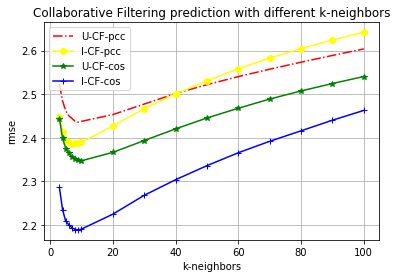

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k,rmse_u_pcc,'-.',c='red',label='U-CF-pcc')
plt.plot(k,rmse_i_pcc,'-o',c='yellow',label='I-CF-pcc')
plt.plot(k,rmse_u_cos,'-*',c='green',label='U-CF-cos')
plt.plot(k,rmse_i_cos,'-+',c='blue',label='I-CF-cos')
plt.title('Collaborative Filtering prediction with different k-neighbors')
plt.xlabel('k-neighbors')
plt.ylabel('rmse')
plt.legend(loc='upper left')
plt.grid()